In [1]:
import flopy as fp
import numpy as np
import geopandas as gp
import pandas as pd
import os
from osgeo import ogr
import gdal
import matplotlib.pyplot as plt
from flopy.utils.gridgen import Gridgen 
from flopy.utils.gridintersect import GridIntersect
from flopy.utils import Raster
import shapely
from shapely.geometry import Polygon, Point, LineString, MultiLineString, MultiPoint, MultiPolygon,shape
from shapely.strtree import STRtree  
import glob

from Rouss1 import gp2idomain, gp2cellids, get_heads, get_spdis, get_MNTbbox, import_riv
from Rouss1 import inter_lst,get_cellcenters, lin_interp

flopy is installed in C:\Users\schorppl\AppData\Local\Continuum\anaconda3\lib\site-packages\flopy


In [2]:
model_dir = "working"
model_name = "2D_Q"
exe_name= "../../exe/mf6"

In [3]:
R_path="../data/limiteQ2.shp" # path to the shp of the aquifer


MNT_path= "../../data/txt_couches/s1_mnt.txt"
sub_path = "../../data/txt_couches/s2_ToitPlioC_MurQuat.txt"

Agly_path= "../data/Fleuves/Agly_ludo.shp" # path to Agly
Tet_path= "../data/Fleuves/Tet_ludo.shp"
Rea_path = "../data/Fleuves/Reart_ludo.shp"
Tech_path = "../data/Fleuves/Tech_ludo.shp"

BCflux_path = "../data/flux_lim/Flux_limite_QUAT1961_63.grd"

In [4]:
def load_flux_bc(path,g):
    
    """
    resample a raster file to a new resolution given a certain grid, made to import the bc flux map
    """
    Qlim = Raster.load(path)
    x0,x1,y0,y1 = Qlim.bounds
    values = Qlim.get_array(1)
    #values[values==-999]=None
    nrow,ncol = values.shape
    Lx = x1-x0
    Ly = y1-y0
    dx = Lx/ncol
    dy = Ly/nrow
    area = dx*dy
    
    Qlim_resample=Qlim.resample_to_grid(grid.xcellcenters,
                                grid.ycellcenters,
                                band = Qlim.bands[0],
                                method="nearest")
    
    Qlim_resample[Qlim_resample==-999]=None
    return Qlim_resample/area

In [5]:
def linInt_Dfcol(df,weight="lengths",col="head",null=0):
    
    """
    function that linearly interpolates the values in a column btwn certains given values, a null value is indicated by 0
    this function needs the lin_interp function, a weighting factor must be provided and a column in the df.
    """
    
    new_heads=np.zeros([df.shape[0]])
    for i in np.arange(df[df[col]!=null].index.shape[0]-1):
        idx1 = df[df[col]!=null].index[i]
        idx2 = df[df[col]!=null].index[i+1]
        new_heads[idx1:idx2+1] = lin_interp(df[weight][idx1:idx2+1],df[col][idx1],df[col][idx2])
        
    df[col]=new_heads

In [6]:
x0,y0,x1,y1 = get_MNTbbox(MNT_path)
x1 -= 2e4;x0 -= 2000

Lx = x1-x0
Ly = y1-y0
nlay = 1
ncol = nrow = 100
delr = np.ones(ncol)*(Lx/ncol)
delc = np.ones(nrow)*(Ly/nrow)
top = 10. # if no mnt is provided
idomain = np.zeros((nrow*ncol))

In [155]:
# resample the top and botm data
grid = fp.discretization.StructuredGrid(delc,delr,xoff=x0,yoff=y0)

MNT = Raster.load(MNT_path)
top = MNT.resample_to_grid(grid.xcellcenters,
                                grid.ycellcenters,
                                band = MNT.bands[0],
                                method="nearest")

BOT = Raster.load(sub_path)
botm = BOT.resample_to_grid(grid.xcellcenters,
                                grid.ycellcenters,
                                band = BOT.bands[0],
                                method="nearest")


In [8]:
R = gp.read_file(R_path) # import shapefile with geopandas

#cells inside the aquifer become active and return the lst of the cellids
lst_domain = gp2idomain(R,grid,idomain,area=0) # all the cells of the model

In [9]:
#recharge
rcha=[]
rch_areas = Raster.load("../data/recharge/rast_peff.tif")
rcha = rch_areas.resample_to_grid(grid.xcellcenters,
                            grid.ycellcenters,
                            band = rch_areas.bands[0],
                            method="nearest")

rcha[rcha==0]=np.mean(rcha[rcha!=0])
coeff = 0.5 # part de pluie qui s'infiltre
rcha *= coeff

In [10]:
# flux at boundaries
Q_bc=load_flux_bc(BCflux_path,grid)
Q_bc[np.isnan(Q_bc)]=0

In [11]:
### BC sea

# import the shapefile that correspond to the BC
BCsea_path = "../data/Sea_BC_L93.shp"
BC_sea = gp.read_file(BCsea_path)

# extract cellids from the BC at the sea and make these cells active
lst_chd = gp2cellids(grid,BC_sea,idomain,type="line")

# attribute a constant head at all the cells in the lst_chd
CHD = 0; chd_lst=[];
for x in lst_chd:
    chd_lst.append((x,CHD))

In [12]:
# BC etangs
BCetangs_path = "../../data/shp/Surface_hydro/SURFACE_HYDROGRAPHIQUE.shp"
Bcet = gp.read_file(BCetangs_path)
etangs = Bcet[(Bcet["TOPONYME"]=="étang de canet") | (Bcet["TOPONYME"]=="étang de leucate")]

# extract cellids from the BC 
etangs_chd = gp2cellids(grid,etangs.dissolve(by="NATURE"),idomain,areas=10)

# attribute a constant head
CHD = 0; et_chd_lst=[];
for x in etangs_chd:
    et_chd_lst.append((x,CHD))

In [56]:
# BC Agly
BC_Agly = gp.read_file(Agly_path) # read shp, linestring from ups to dws
df_agy = import_riv(grid,BC_Agly) # extract cellids intersected + lengths in each cells
df_agy["xc"],df_agy["yc"] = get_cellcenters(grid,df_agy.cellids)
df_agy["head"] = np.zeros([df_agy.shape[0]])

# station(s) and assignement of heads
xs = 691850.9; ys = 6185873.7; elev = 11.39
dist = ((df_agy["xc"] - xs)**2 + (df_agy["yc"] - ys)**2)**0.5
df_agy["head"][dist==np.min(dist)] = elev + 1

# us and ds heads
df_agy["head"].iloc[0] = 28
df_agy["head"].iloc[-1] = 0.1

# interpolation of the heads btw ups,stations and ds
linInt_Dfcol(df_agy,col="head")

#drop cellids which are already constant head
a = inter_lst(df_agy.cellids, lst_chd)
for i in range (len(a)):
    df_agy = df_agy.drop(df_agy[df_agy["cellids"] == a[i]].index)

# create the stress package
H_riv = df_agy["head"]
Agy_chd=[]; o =-1;
for x in df_agy.cellids:
    o = o + 1
    Agy_chd.append((x,H_riv[o]))

C:\Users\schorppl\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\frame.py:7123: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,
C:\Users\schorppl\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
C:\Users\schorppl\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.

In [13]:
## BC Tet
gp_Tet = gp.read_file(Tet_path)
df_tet = import_riv(grid,gp_Tet)  
df_tet["xc"],df_tet["yc"] = get_cellcenters(grid,df_tet.cellids)
df_tet["head"] = np.zeros([df_tet.shape[0]])

# us and ds heads
df_tet["head"].iloc[-1] = 0.1

#add the head of the stations
Tet_stations=pd.read_csv("../data/stations_tet.csv",sep=";") # import the stations in a df
for i in Tet_stations.index: # attribute a head value to the closest point of the the station
    xs = Tet_stations.loc[i].x
    ys = Tet_stations.loc[i].y
    elev = Tet_stations.loc[i].elev
    dist = ((df_tet["xc"] - xs)**2 + (df_tet["yc"] - ys)**2)**0.5
    df_tet["head"][dist==np.min(dist)] = elev + 1

# interpolation of the heads btw ups,stations and ds
linInt_Dfcol(df_tet,col="head")

#drop cellids which are already constant heads
for cellid in df_tet.cellids:
    if cellid in lst_chd:
        df_tet = df_tet.drop(df_tet[df_tet["cellids"] == cellid].index)
    if cellid not in lst_domain:
        df_tet = df_tet.drop(df_tet[df_tet["cellids"]== cellid].index)

df_tet = df_tet.reset_index()
H_riv = df_tet["head"]
# create the stress package
Tet_chd=[]; o =-1;
for x in df_tet.cellids:
    o = o + 1
    Tet_chd.append((x,H_riv[o]))

C:\Users\schorppl\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\frame.py:7123: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,
C:\Users\schorppl\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
C:\Users\schorppl\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/panda

In [40]:
#BC Tech
gp_riv = gp.read_file(Tech_path)
df_riv = import_riv(grid,gp_riv) # extract cellids from the river, in order with associated lengths   
df_riv["xc"],df_riv["yc"] = get_cellcenters(grid,df_riv.cellids)
df_riv["head"] = np.zeros([df_riv.shape[0]])

# ds heads
df_riv["head"].iloc[-1] = 0.1

#add the head of the stations
Tech_stations=pd.read_csv("../data/stations_tech.csv",sep=";") # import the stations in a df
for i in Tech_stations.index: # attribute a head value to the closest point of the the station
    xs = Tech_stations.loc[i].x
    ys = Tech_stations.loc[i].y
    elev = Tech_stations.loc[i].elev
    dist = ((df_riv["xc"] - xs)**2 + (df_riv["yc"] - ys)**2)**0.5
    df_riv["head"][dist==np.min(dist)] = elev + 1 #issue warning ? but works

# interpolation of the heads btw ups,stations and ds
linInt_Dfcol(df_riv,col="head")

# assign heads along the river
# df_riv["head"] = lin_interp(df_riv.lengths,125,0)

# drop some cells
for cellid in df_riv.cellids:
    if (cellid in lst_chd) | (cellid in etangs_chd):
        df_riv = df_riv.drop(df_riv[df_riv["cellids"] == cellid].index)
    if cellid not in lst_domain:
        df_riv = df_riv.drop(df_riv[df_riv["cellids"]== cellid].index)

df_riv = df_riv.reset_index()
H_riv = df_riv["head"]
# create the stress package
Tech_chd=[]; o =-1;
for x in df_riv.cellids:
    o = o + 1
    Tech_chd.append((x,H_riv[o]))

C:\Users\schorppl\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\frame.py:7123: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,
C:\Users\schorppl\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
C:\Users\schorppl\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/panda

In [164]:
sim = fp.mf6.MFSimulation(sim_name='theis_mf6', version='mf6', exe_name=exe_name, 
                             sim_ws=model_dir)
gwf = fp.mf6.ModflowGwf(sim, modelname=model_name,
                           model_nam_file='{}.nam'.format(model_name))


top[top==-9999]=1
top[(top-botm)<=0]=botm[(top-botm)<=0]+0.1
botm[botm==-9999]=-100
dis = fp.mf6.ModflowGwfdis(gwf, nlay=nlay, nrow=nrow, ncol=ncol,
                              delr=delr, delc=delc,
                              top=top, botm=botm,xorigin=x0,yorigin=y0,idomain=idomain)

tdis = fp.mf6.ModflowTdis(sim, time_units='SECONDS',perioddata=[[1.0, 1, 1.]])
ims  = fp.mf6.ModflowIms(sim, print_option='SUMMARY', complexity='simple')

# initial conditions
ic   = fp.mf6.ModflowGwfic(gwf,strt=botm)

# nodeflowproperty
kh = 5e-4
npf  = fp.mf6.ModflowGwfnpf(gwf, icelltype=0, k=kh, save_flows=True,save_specific_discharge=True)

# recharge

rch  = fp.mf6.ModflowGwfrcha(gwf, recharge = 0*Q_bc+(rcha/1000/365/86400))

# output control
oc   = fp.mf6.ModflowGwfoc(gwf,budget_filerecord='{}.cbc'.format(model_name),
                            head_filerecord='{}.hds'.format(model_name),
                            saverecord=[('HEAD', 'LAST'),
                                        ('BUDGET', 'ALL')],
                            printrecord=[('HEAD', 'LAST'),
                                         ('BUDGET', 'ALL')])

# constant heads packages
chd = fp.mf6.modflow.mfgwfchd.ModflowGwfchd(gwf, pname='sea', filename="sea.chd", maxbound=len(chd_lst), 
                                               stress_period_data={0: chd_lst}, save_flows=True)

etangs = fp.mf6.modflow.mfgwfchd.ModflowGwfchd(gwf, pname='eta', filename="eta.chd", maxbound=len(et_chd_lst), 
                                               stress_period_data={0: et_chd_lst}, save_flows=True)


Agly = fp.mf6.modflow.mfgwfchd.ModflowGwfchd(gwf, pname='agy', filename="agy.chd", maxbound=len(Agy_chd), 
                                              stress_period_data={0: Agy_chd}, save_flows=True)
Tet = fp.mf6.modflow.mfgwfchd.ModflowGwfchd(gwf, pname='Tet', filename="Tet.chd", maxbound=len(Tet_chd), 
                                               stress_period_data={0: Tet_chd}, save_flows=True)
Tech = fp.mf6.modflow.mfgwfchd.ModflowGwfchd(gwf, pname='Tech', filename="Tech.chd", maxbound=len(Tech_chd), 
                                               stress_period_data={0: Tech_chd}, save_flows=True)

In [165]:
sim.write_simulation()
sim.run_simulation()

writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing ims package ims_-1...
  writing model 2D_Q...
    writing model name file...
    writing package dis...
    writing package ic...
    writing package npf...
    writing package rcha...
    writing package oc...
    writing package sea...
    writing package eta...
    writing package agy...
    writing package tet...
    writing package tech...
FloPy is using the following  executable to run the model: ../../exe/mf6.exe
                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                            VERSION 6.0.4 03/13/2019

   MODFLOW 6 compiled Mar 21 2019 15:37:31 with IFORT compiler (ver. 19.0.0)

This software has been approved for release by the U.S. Geological 
Survey (USGS). Although the software has been subjected to rigorous 
review, the USGS reserves the right to update the software as needed 
pursuant to further analy

(True, [])

In [166]:
# retrieve heads and spdis 
head = get_heads(model_name,model_dir)
spdis = get_spdis(model_name,model_dir)

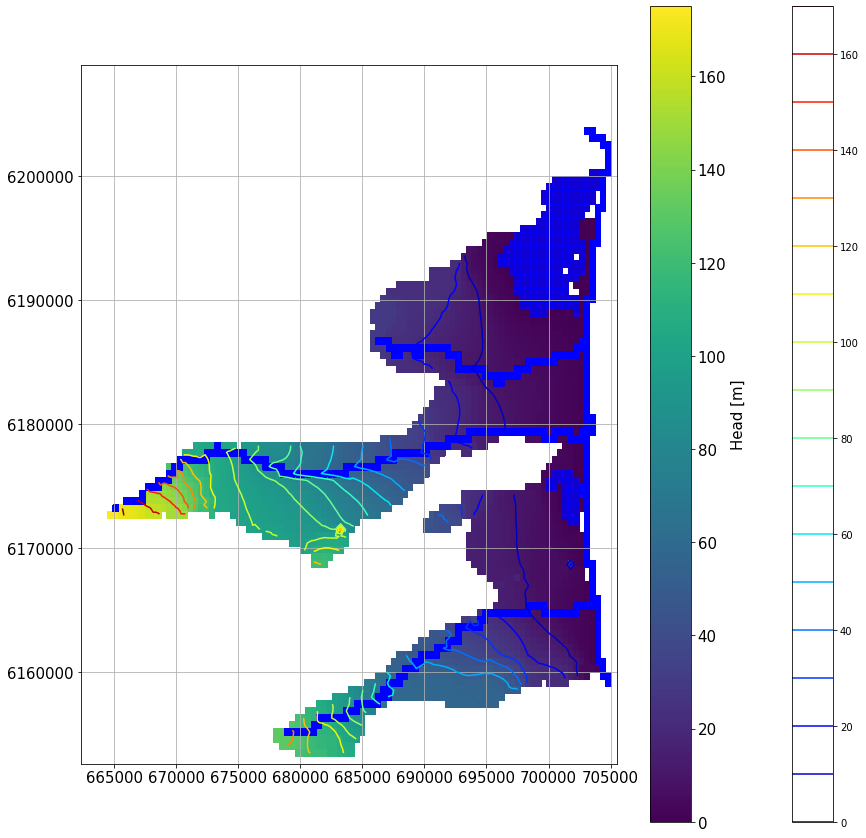

In [167]:
# make a plot
fig = plt.figure(figsize=(15,15))
ax  = plt.subplot(1, 1, 1, aspect='equal')
ml = fp.plot.PlotMapView(model=gwf)

#hmesh=ml.plot_ibound()
hmesh=ml.plot_array(head,masked_values=[1e30],cmap="viridis")
cont=ml.contour_array(head,masked_values=[1e30],levels=np.linspace(0,170,18),cmap="jet")
#ml.plot_specific_discharge(spdis[0],color="w",width=0.0050)

ml.plot_bc("sea",color="b")
ml.plot_bc("eta",color="b",alpha=0.5)
ml.plot_bc("Tet",color="b")
ml.plot_bc("agy",color="b")
ml.plot_bc("tech",color="b")

ax.tick_params(labelsize=15)

h = plt.colorbar(cont)
g = plt.colorbar(hmesh)
g.set_label("Head [m]",fontsize=15)
g.ax.tick_params(labelsize=15)
plt.grid()

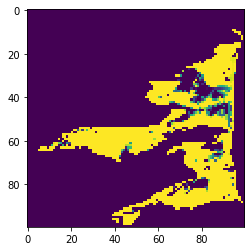

In [171]:
a=plt.imshow(top-head[0])
a.set_clim(0,1)

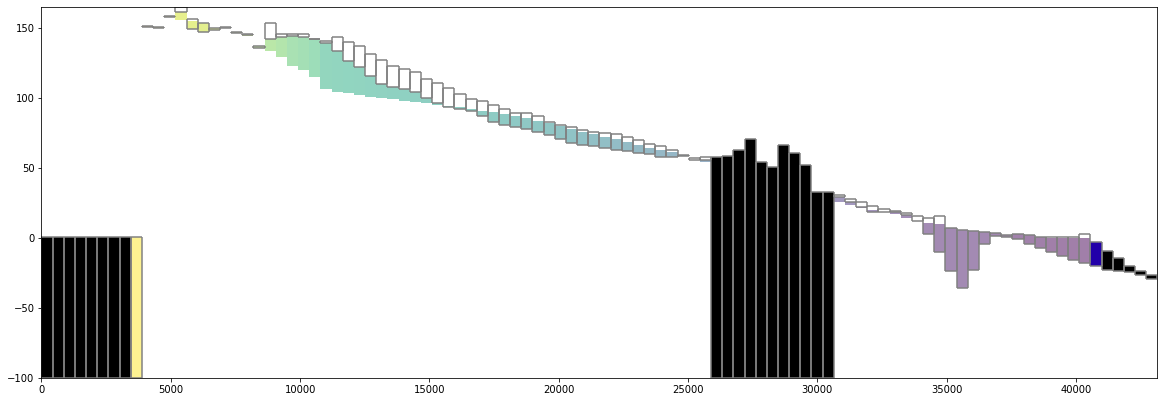

In [182]:
fig = plt.figure(figsize=(20, 15))
ax = fig.add_subplot(2, 1, 1)

xsect = fp.plot.PlotCrossSection(model=gwf, line={'row': 62})
patches = xsect.plot_ibound()
patches = xsect.plot_bc("sea",color="b")
csa = xsect.plot_array(head, masked_values=[1e30], head=head, alpha=0.5)
linecollection = xsect.plot_grid()